### Imports

In [1]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import math
from sklearn.decomposition import PCA

## Leitura do ficheiro

In [2]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

In [3]:
file = data_folder / "QuebrasJuntoInc.xlsx"
QuebrasFinal = pd.read_excel(file)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828,"0,0029345","0,0000443","0,0024563",...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549,"0,0029335","0,0001770","0,0165009",...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459,"0,0192281","0,0002655","0,0359047",...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102,"0,0000000","0,0000000","0,0000000",...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731,"0,0044221","0,0001549","0,0100377",...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7724,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7725,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7726,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [4]:
QuebrasFinal["Ano"].unique()

array([2018, 2021, 2022, 2023, 2019, 2020, 2014, 2015, 2016, 2017],
      dtype=int64)

## Breve tratamento de dados

In [5]:
# Remover colunas desnecessárias
columnsRemove = ['Qualidade de Energia Elétrica', 'Qualidade de Serviço Comercial', 'Fundamentação']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

# Substituir as vírgulas por pontos nas colunas supostamente numéricas
colunas_string = QuebrasFinal.iloc[:, 5:33].select_dtypes(include=['object']).columns
QuebrasFinal[colunas_string] = QuebrasFinal[colunas_string].replace(',', '.', regex=True)

# Lista das colunas a serem convertidas
colunas_para_converter = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 
                          'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)', 'N.º clientes afetados']

# Converter as colunas para o tipo float
QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828.0,0.002935,0.000044,0.002456,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549.0,0.002933,0.000177,0.016501,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459.0,0.019228,0.000266,0.035905,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.000000,0.000000,0.000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731.0,0.004422,0.000155,0.010038,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.000000,0.000000,0.000000,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7724,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.000000,0.000000,0.000000,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7725,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.000000,0.000000,0.000000,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7726,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154.0,1.0,0.000000,0.000000,0.000000,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


### Criação de Variáveis

In [6]:
QuebrasFinal = QuebrasFinal[(QuebrasFinal["Nível de Tensão"] == "BT") | (QuebrasFinal["Nível de Tensão"] == "MT")].reset_index(drop=True)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828.0,0.002935,0.000044,0.002456,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549.0,0.002933,0.000177,0.016501,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459.0,0.019228,0.000266,0.035905,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.000000,0.000000,0.000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731.0,0.004422,0.000155,0.010038,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2.0,0.000000,0.000000,0.000000,...,119.8,0.000000,12.5,17.7,6.1,28.0,326.0,NaN,NaN,1.3
7456,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.000000,0.000000,0.000000,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7457,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.000000,0.000000,0.000000,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7458,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.000000,0.000000,0.000000,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1


### Tipo de tensão

In [7]:
QuebrasFinal["Ser_BT?"] = np.where(QuebrasFinal["Nível de Tensão"] == "BT", 1, 0)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Ser_BT?
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828.0,0.002935,0.000044,0.002456,...,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0,0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549.0,0.002933,0.000177,0.016501,...,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0,0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459.0,0.019228,0.000266,0.035905,...,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0,0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.000000,0.000000,0.000000,...,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2,1
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731.0,0.004422,0.000155,0.010038,...,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2.0,0.000000,0.000000,0.000000,...,0.000000,12.5,17.7,6.1,28.0,326.0,NaN,NaN,1.3,1
7456,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.000000,0.000000,0.000000,...,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0,1
7457,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.000000,0.000000,0.000000,...,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN,1
7458,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.000000,0.000000,0.000000,...,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1,1


### Causas

In [8]:
# Lista de categorias de causas de incidentes pertencentes a cada grande classe
humanosAcidente = ['Escavações', 'Abate De Árvores', 'Veículos', 'Incêndio', 
           'Risco Iminente Pessoas Ou Bens', 'Trabalhos De Terceiros ( Gruas,... )', 
           'Intervenções À Superficie', 'Desabamento De Muros/Outras Construções', 
         'Ruptura De Canal. De Fluídos', 'Desabamento De Muros/Outras Cons']

humanosIntenção = ['Malfeitorioa (Vandalismo)', 'Malfeitoria/Vandalismo', 'Furtos', 'Sabotagem',]

animais = ['Aves', 'Animais Não Aves', 'Corpos Estranhos Na Rede']

clima = ['Deslizamento De Terras', 'Terramoto', 'Neve/Gelo/Granizo Condição Excecional', 
         'Vento Intensidade Excepcional', 'Descarga Atmosférica Directa',  
         'Inundações Imprevisíveis']

# Função para atribuir a classe correspondente com base na causa do incidente
def assign_class(cause):
    if cause in humanosAcidente:
        return 'Humanos - Acidentes'
    elif cause in humanosIntenção:
        return 'Humanos - Intenção'
    elif cause in animais:
        return 'Animais'
    elif cause in clima:
        return 'Clima'
    else:
        return 'Outros'

# Criar uma nova coluna com as classes atribuídas
QuebrasFinal['Grande Classe'] = QuebrasFinal['Causa do incidente'].apply(assign_class)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Grande Classe
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828.0,0.002935,0.000044,0.002456,...,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0,0,Humanos - Acidentes
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549.0,0.002933,0.000177,0.016501,...,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0,0,Humanos - Acidentes
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459.0,0.019228,0.000266,0.035905,...,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0,0,Clima
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.000000,0.000000,0.000000,...,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2,1,Humanos - Acidentes
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731.0,0.004422,0.000155,0.010038,...,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9,0,Animais
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2.0,0.000000,0.000000,0.000000,...,12.5,17.7,6.1,28.0,326.0,NaN,NaN,1.3,1,Humanos - Acidentes
7456,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.000000,0.000000,0.000000,...,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0,1,Humanos - Acidentes
7457,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.000000,0.000000,0.000000,...,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN,1,Humanos - Acidentes
7458,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.000000,0.000000,0.000000,...,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1,1,Humanos - Acidentes


In [9]:
# Criar variáveis dummy
dummies = pd.get_dummies(QuebrasFinal["Grande Classe"])

# Converter as variáveis dummy de booleanas para int
dummies = dummies.astype(int)

# Concatenar as variáveis dummy ao DataFrame original
QuebrasFinal = pd.concat([QuebrasFinal, dummies], axis=1)

# Excluir a coluna original "Grande Classe"
QuebrasFinal.drop("Grande Classe", axis=1, inplace=True)

# Exibir o DataFrame com as variáveis dummy convertidas para int
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Animais,Animais - Intenção,Clima,Humanos - Acidentes
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828.0,0.002935,0.000044,0.002456,...,NaN,NaN,NaN,NaN,0.0,0,0,0,0,1
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549.0,0.002933,0.000177,0.016501,...,249.0,270.0,2.8,8.1,0.0,0,0,0,0,1
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459.0,0.019228,0.000266,0.035905,...,197.0,180.0,3.9,14.4,4.0,0,0,0,1,0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.000000,0.000000,0.000000,...,288.0,225.0,3.6,13.9,13.2,1,0,0,0,1
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731.0,0.004422,0.000155,0.010038,...,137.0,118.0,4.1,15.4,15.9,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2.0,0.000000,0.000000,0.000000,...,28.0,326.0,NaN,NaN,1.3,1,0,0,0,1
7456,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.0,1,0,0,0,1
7457,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1
7458,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,8.1,1,0,0,0,1


### Tempo Trigonometria

In [10]:
# Função para verificar se o ano é bissexto
def eh_bissexto(ano):
    return ano % 4 == 0 and (ano % 100 != 0 or ano % 400 == 0)

# Função para calcular o ângulo em radianos com base no dia, mês e ano
def calcular_angulo(dia, mes, ano):
    total_dias = 366 if eh_bissexto(ano) else 365  # Total de dias no ano
    angulo = 2 * np.pi * ((mes - 1) * 31 + dia) / total_dias
    return angulo

# Função para calcular o ângulo para cada linha do DataFrame
def calcular_angulo_para_linha(row):
    dia = row['Dia']
    mes = row['Mês']
    ano = row['Ano']
    return calcular_angulo(dia, mes, ano)

# Aplicar a função calcular_angulo_para_linha em cada linha do DataFrame QuebrasFinal
QuebrasFinal['RadianoData'] = QuebrasFinal.apply(calcular_angulo_para_linha, axis=1)

# Aplicar as funções seno e cosseno aos ângulos
QuebrasFinal['SenoData'] = np.sin(QuebrasFinal['RadianoData'])
QuebrasFinal['CossenoData'] = np.cos(QuebrasFinal['RadianoData'])

# Verificar o resultado
QuebrasFinal[['Dia', 'Mês', 'RadianoData', 'SenoData', 'CossenoData']]

,Dia,Mês,RadianoData,SenoData,CossenoData
0,2,1,0.034428,0.034422,0.999407
1,2,1,0.034428,0.034422,0.999407
2,4,1,0.068857,0.068802,0.997630
3,5,1,0.086071,0.085965,0.996298
4,9,1,0.154928,0.154309,0.988023
...,...,...,...,...,...
7455,25,11,5.766759,-0.493776,0.869589
7456,29,11,5.835616,-0.432776,0.901502
7457,3,11,5.388047,-0.780296,0.625411
7458,23,11,5.732331,-0.523416,0.852078


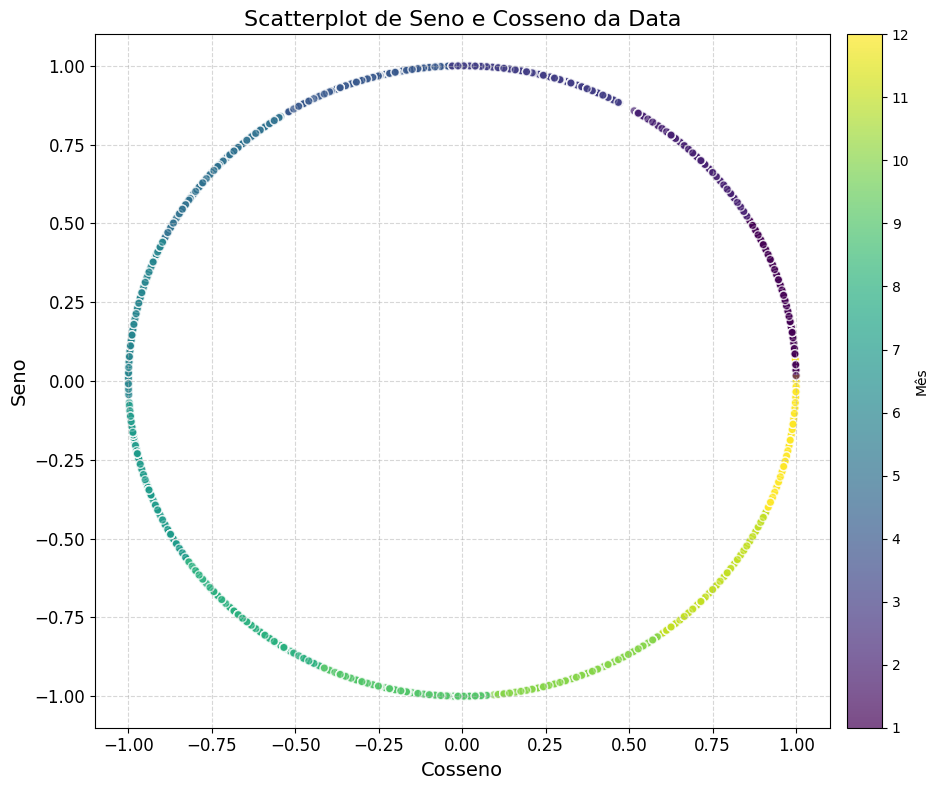

In [11]:
# Plotar o scatterplot
plt.figure(figsize=(10, 8))
plt.scatter(QuebrasFinal['CossenoData'], QuebrasFinal['SenoData'], c=QuebrasFinal['Mês'], cmap='viridis', alpha=0.7, edgecolors='w')
plt.title('Scatterplot de Seno e Cosseno da Data', fontsize=16)
plt.xlabel('Cosseno', fontsize=14)
plt.ylabel('Seno', fontsize=14)
plt.colorbar(label='Mês', ticks=range(1, 13), pad=0.02)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Apagar colunas

In [12]:
QuebrasFinal.columns

Index(['Código do Relatório', 'Concelho', 'Data do incidente',
       'Nível de Tensão', 'Causa do incidente', 'Duração incidente (min)',
       'N.º clientes afetados', 'TIEPI MT (min)', 'SAIFI MT (#)',
       'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)',
       'Decisão', 'Dia', 'Mês', 'Ano', 'Distrito', 'Bibliotecas e Arquivos',
       'Desporto e Lazer', 'Edifícios degradados ou devolutos',
       'Espectáculos e Reuniões Públicas', 'Estacionamento de superfície',
       'Estacionamento em profundidade ou silo', 'Habitacional',
       'Hospitalares e Lares de Idosos', 'Hotelaria e Restauração',
       'Indústria, Oficina e Armazém',
       'Militar, Forças de Segurança e Forças de Socorro',
       'Museus e Galerias de Arte', 'Parque Escolar',
       'Serviços Administrativos', 'Áreas Comerciais e Gares de Transportes',
       'Ocorrências', 'MeiosTerrestres', 'Duração Minutos',
       'Densidade Populacional', 'População Residente', 'Setor Primário',
       'Set

In [13]:
columnsRemove = ['Ocorrências', 'Indústria, Oficina e Armazém', 'Edifícios degradados ou devolutos', 'Habitacional','População Residente', 'MeiosTerrestres', 'Duração Minutos', 'RadianoData', 'Nível de Tensão', 'Causa do incidente', 'Bibliotecas e Arquivos', 'Desporto e Lazer', 'Espectáculos e Reuniões Públicas', 'Estacionamento de superfície', 'Estacionamento em profundidade ou silo', 'Hospitalares e Lares de Idosos', 'Hotelaria e Restauração', 'Militar, Forças de Segurança e Forças de Socorro', 'Museus e Galerias de Arte', 'Parque Escolar', 'Serviços Administrativos', 'Áreas Comerciais e Gares de Transportes']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

In [14]:
QuebrasFinal.columns

Index(['Código do Relatório', 'Concelho', 'Data do incidente',
       'Duração incidente (min)', 'N.º clientes afetados', 'TIEPI MT (min)',
       'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)',
       'SAIDI BT (min)', 'Decisão', 'Dia', 'Mês', 'Ano', 'Distrito',
       'Densidade Populacional', 'Setor Primário', 'Setor Secundário',
       'Setor Terciário', 'Indice de Envelhecimento', 'Rural', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD',
       'Ser_BT?', 'Animais', 'Animais - Intenção', 'Clima',
       'Humanos - Acidentes', 'SenoData', 'CossenoData'],
      dtype='object')

In [15]:
QuebrasFinal.dtypes

Código do Relatório          object
Concelho                     object
Data do incidente            object
Duração incidente (min)     float64
N.º clientes afetados       float64
TIEPI MT (min)              float64
SAIFI MT (#)                float64
SAIDI MT (min)              float64
END (MWh)                   float64
SAIFI BT (#)                float64
SAIDI BT (min)              float64
Decisão                      object
Dia                           int64
Mês                           int64
Ano                           int64
Distrito                     object
Densidade Populacional      float64
Setor Primário                int64
Setor Secundário              int64
Setor Terciário               int64
Indice de Envelhecimento    float64
Rural                       float64
T_MED                       float64
T_MAX                       float64
T_MIN                       float64
DD_MED                      float64
DD_FFX                      float64
FF_MED                      

In [16]:
QuebrasFinal["Setor Primário"]

0        384
1        348
2        384
3       2672
4        165
        ... 
7455     586
7456     290
7457     405
7458     405
7459    1148
Name: Setor Primário, Length: 7460, dtype: int64

## Outliers

In [17]:
# Selecionar as colunas específicas
colunas_outliers = ["Duração incidente (min)", "TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)", "SAIFI BT (#)", "SAIDI BT (min)"]

# Calcular os quartis e o intervalo interquartil (IQR) apenas para as colunas específicas
Q1_outliers = QuebrasFinal[colunas_outliers].quantile(0.25)
Q3_outliers = QuebrasFinal[colunas_outliers].quantile(0.75)
IQR_outliers = Q3_outliers - Q1_outliers

# Definir os limites inferior e superior para detecção de outliers para as colunas específicas
limite_inferior_outliers = Q1_outliers - 3 * IQR_outliers
limite_superior_outliers = Q3_outliers + 3 * IQR_outliers

# Remover linhas com outliers nas colunas específicas
QuebrasFinal_sem_outliers_especificos = QuebrasFinal[~((QuebrasFinal[colunas_outliers] < limite_inferior_outliers) | (QuebrasFinal[colunas_outliers] > limite_superior_outliers)).any(axis=1)]
QuebrasFinal = QuebrasFinal_sem_outliers_especificos.reset_index(drop=True)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),...,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Animais,Animais - Intenção,Clima,Humanos - Acidentes,SenoData,CossenoData
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,55.0,828.0,0.002935,0.000044,0.002456,0.213525,0.000136,...,NaN,NaN,0.0,0,0,0,0,1,0.034422,0.999407
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,163.0,549.0,0.002933,0.000177,0.016501,0.213452,0.000090,...,2.8,8.1,0.0,0,0,0,0,1,0.034422,0.999407
2,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,178.0,102.0,0.000000,0.000000,0.000000,0.000000,0.000017,...,3.6,13.9,13.2,1,0,0,0,1,0.085965,0.996298
3,EDPD_2018_JAN_T_5,Nisa,2018-01-09,119.0,1731.0,0.004422,0.000155,0.010038,0.321769,0.000052,...,4.1,15.4,15.9,0,1,0,0,0,0.154309,0.988023
4,EDPD_2018_JAN_T_6,Esposende,2018-01-12,76.0,60.0,0.000000,0.000000,0.000000,0.000000,0.000010,...,NaN,NaN,1.4,1,0,0,0,1,0.205104,0.978740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,EDPD_2017_NOV_T_61,Esposende,2017-11-25,235.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,1.3,1,0,0,0,1,-0.493776,0.869589
6787,EDPD_2017_NOV_T_62,Ovar,2017-11-29,220.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,0.0,1,0,0,0,1,-0.432776,0.901502
6788,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,92.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,1,0,0,0,1,-0.780296,0.625411
6789,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,121.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,8.1,1,0,0,0,1,-0.523416,0.852078


## Estandardizar/Normalizar os dados

In [18]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number, bool]).columns
colunas_numericas

Index(['Duração incidente (min)', 'N.º clientes afetados', 'TIEPI MT (min)',
       'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)',
       'SAIDI BT (min)', 'Dia', 'Mês', 'Ano', 'Densidade Populacional',
       'Setor Primário', 'Setor Secundário', 'Setor Terciário',
       'Indice de Envelhecimento', 'Rural', 'T_MED', 'T_MAX', 'T_MIN',
       'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD', 'Ser_BT?', 'Animais',
       'Animais - Intenção', 'Clima', 'Humanos - Acidentes', 'SenoData',
       'CossenoData'],
      dtype='object')

In [19]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),...,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Animais,Animais - Intenção,Clima,Humanos - Acidentes,SenoData,CossenoData
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,-1.010792,-0.032791,-0.159443,-0.378273,-0.415923,-0.145194,0.499487,...,NaN,NaN,-0.367508,-1.068771,-0.486802,-0.498343,-0.233459,0.890374,0.003044,1.544262
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,0.300274,-0.243748,-0.159612,0.445224,0.871489,-0.145366,0.118604,...,-0.152666,-0.592220,-0.367508,-1.068771,-0.486802,-0.498343,-0.233459,0.890374,0.003044,1.544262
2,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,0.482367,-0.581733,-0.655758,-0.653186,-0.641083,-0.652376,-0.492309,...,0.415629,1.079844,1.379561,0.935654,-0.486802,-0.498343,-0.233459,0.890374,0.074743,1.539762
3,EDPD_2018_JAN_T_5,Nisa,2018-01-09,-0.233864,0.649984,0.092157,0.308078,0.279033,0.111917,-0.199771,...,0.770814,1.512274,1.736916,-1.068771,2.054223,-0.498343,-0.233459,-1.123123,0.169813,1.527787
4,EDPD_2018_JAN_T_6,Esposende,2018-01-12,-0.755862,-0.613490,-0.655758,-0.653186,-0.641083,-0.652376,-0.549816,...,NaN,NaN,-0.182213,0.935654,-0.486802,-0.498343,-0.233459,0.890374,0.240471,1.514355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,EDPD_2017_NOV_T_61,Esposende,2017-11-25,1.174319,-0.657345,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,NaN,NaN,-0.195448,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-0.731700,1.356409
6787,EDPD_2017_NOV_T_62,Ovar,2017-11-29,0.992226,-0.657345,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,NaN,NaN,-0.367508,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-0.646847,1.402588
6788,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,-0.561630,-0.658101,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,NaN,NaN,NaN,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-1.130262,1.003072
6789,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,-0.209585,-0.658101,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,NaN,NaN,0.704557,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-0.772931,1.331069


## Imputação dos dados

In [20]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal


C:\Users\diogo\scoop\apps\anaconda3\2022.10\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Código do Relatório,Concelho,Data do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),...,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Animais,Animais - Intenção,Clima,Humanos - Acidentes,SenoData,CossenoData
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,-1.010792,-0.032791,-0.159443,-0.378273,-0.415923,-0.145194,0.499487,...,-0.256493,-0.198123,-0.367508,-1.068771,-0.486802,-0.498343,-0.233459,0.890374,0.003044,1.544262
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,0.300274,-0.243748,-0.159612,0.445224,0.871489,-0.145366,0.118604,...,-0.152666,-0.592220,-0.367508,-1.068771,-0.486802,-0.498343,-0.233459,0.890374,0.003044,1.544262
2,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,0.482367,-0.581733,-0.655758,-0.653186,-0.641083,-0.652376,-0.492309,...,0.415629,1.079844,1.379561,0.935654,-0.486802,-0.498343,-0.233459,0.890374,0.074743,1.539762
3,EDPD_2018_JAN_T_5,Nisa,2018-01-09,-0.233864,0.649984,0.092157,0.308078,0.279033,0.111917,-0.199771,...,0.770814,1.512274,1.736916,-1.068771,2.054223,-0.498343,-0.233459,-1.123123,0.169813,1.527787
4,EDPD_2018_JAN_T_6,Esposende,2018-01-12,-0.755862,-0.613490,-0.655758,-0.653186,-0.641083,-0.652376,-0.549816,...,-0.485843,-0.240559,-0.182213,0.935654,-0.486802,-0.498343,-0.233459,0.890374,0.240471,1.514355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,EDPD_2017_NOV_T_61,Esposende,2017-11-25,1.174319,-0.657345,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,-0.467685,-0.414660,-0.195448,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-0.731700,1.356409
6787,EDPD_2017_NOV_T_62,Ovar,2017-11-29,0.992226,-0.657345,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,-0.211303,-0.340958,-0.367508,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-0.646847,1.402588
6788,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,-0.561630,-0.658101,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,-0.327596,-0.349455,0.363256,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-1.130262,1.003072
6789,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,-0.209585,-0.658101,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,-0.340687,-0.303483,0.704557,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-0.772931,1.331069


In [21]:
QuebrasFinal[QuebrasFinal.isna().any(axis=1)]

,Código do Relatório,Concelho,Data do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),...,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Animais,Animais - Intenção,Clima,Humanos - Acidentes,SenoData,CossenoData


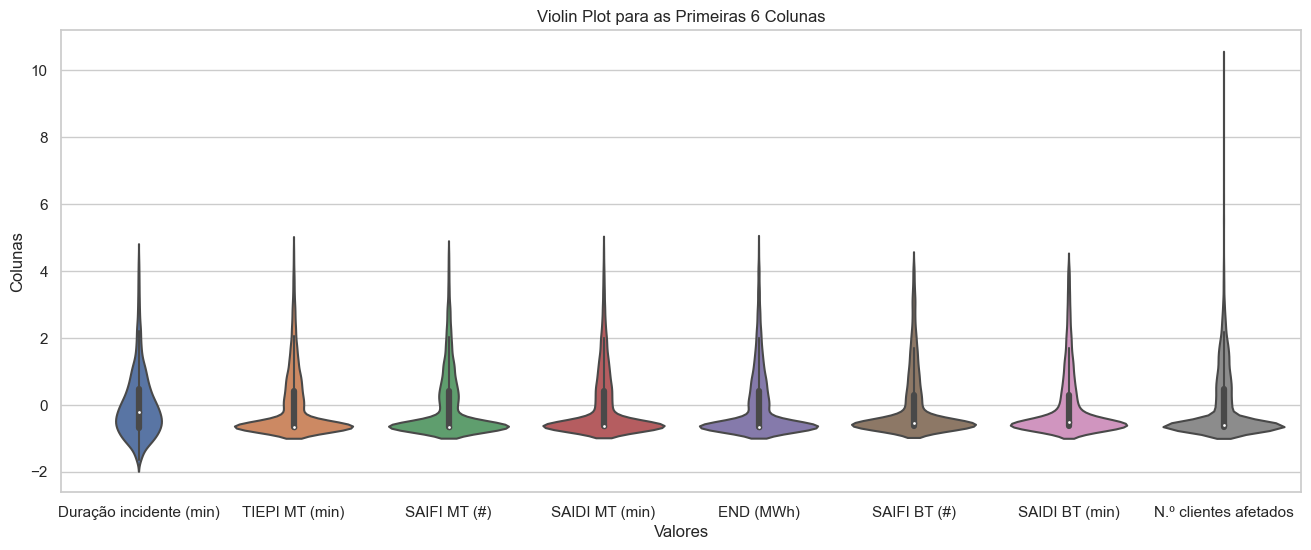

In [22]:
sns.set(style="whitegrid")

ColunasInteresse = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)', 'N.º clientes afetados']

# Obter os índices das colunas numéricas
indices_col_numericas = [QuebrasFinal.columns.get_loc(col) for col in ColunasInteresse]

# Selecionar as colunas numéricas utilizando os índices
subset_quebras_final = QuebrasFinal.iloc[:, indices_col_numericas]

# Plotar violin plot para as primeiras 6 colunas
plt.figure(figsize=(16, 6))
sns.violinplot(data=subset_quebras_final)
plt.title("Violin Plot para as Primeiras 6 Colunas")
plt.xlabel("Valores")
plt.ylabel("Colunas")
plt.show()

## PCA

In [23]:
colunas_numericas = colunas_numericas.delete([colunas_numericas.get_loc("Dia"), colunas_numericas.get_loc("Mês")])
colunas_numericas

Index(['Duração incidente (min)', 'N.º clientes afetados', 'TIEPI MT (min)',
       'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)',
       'SAIDI BT (min)', 'Ano', 'Densidade Populacional', 'Setor Primário',
       'Setor Secundário', 'Setor Terciário', 'Indice de Envelhecimento',
       'Rural', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED',
       'FF_MAX', 'PR_QTD', 'Ser_BT?', 'Animais', 'Animais - Intenção', 'Clima',
       'Humanos - Acidentes', 'SenoData', 'CossenoData'],
      dtype='object')

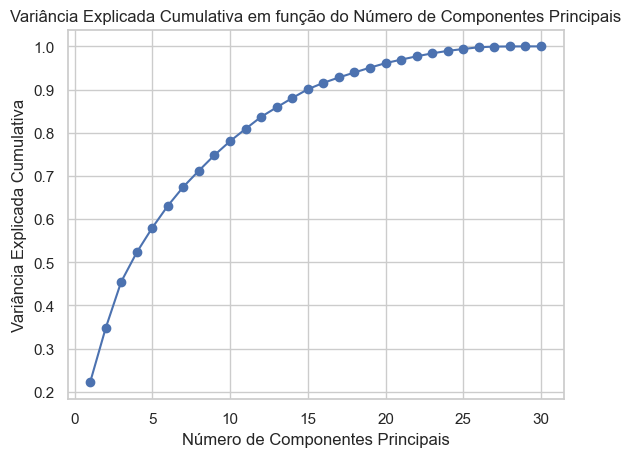

In [24]:
indices_col_numericas = QuebrasFinal.columns.get_indexer(colunas_numericas)

# Calcular PCA para diferentes números de componentes
num_componentes_max = min(QuebrasFinal.iloc[:, indices_col_numericas].shape)  # Número máximo de componentes = min(Número de linhas, Número de colunas)
var_explicada_cumulativa = []
for num_componentes in range(1, num_componentes_max + 1):
    pca = PCA(n_components=num_componentes)
    pca.fit(QuebrasFinal.iloc[:, indices_col_numericas])
    var_explicada_cumulativa.append(sum(pca.explained_variance_ratio_))

# Plotar a variância explicada acumulada em função do número de componentes
plt.plot(range(1, num_componentes_max + 1), var_explicada_cumulativa, marker='o')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Variância Explicada Cumulativa em função do Número de Componentes Principais')
plt.grid(True)
plt.show()

In [25]:
# Calcular os componentes principais
pca = PCA(n_components=5)  # Vamos manter 3 componentes principais
componentes_principais = pca.fit_transform(QuebrasFinal.iloc[:, indices_col_numericas])

# Obter os vetores de carga (pesos) para cada componente principal
vetores_de_carga = pca.components_

# Criar um DataFrame com os vetores de carga e os nomes das variáveis originais
df_vetores_de_carga = pd.DataFrame(vetores_de_carga, columns=colunas_numericas)

# Mostrar os vetores de carga para cada componente principal
for i, componente in enumerate(df_vetores_de_carga.index):
    print(f' ####### Componente Principal {i+1}: ####### \n')
    print(df_vetores_de_carga.loc[i])
    print()


 ####### Componente Principal 1: ####### 

Duração incidente (min)     0.058476
N.º clientes afetados       0.299136
TIEPI MT (min)              0.338503
SAIFI MT (#)                0.338104
SAIDI MT (min)              0.344480
END (MWh)                   0.338055
SAIFI BT (#)                0.313968
SAIDI BT (min)              0.322929
Ano                         0.189227
Densidade Populacional     -0.068163
Setor Primário              0.004564
Setor Secundário           -0.073805
Setor Terciário            -0.063615
Indice de Envelhecimento    0.080809
Rural                       0.072509
T_MED                      -0.041775
T_MAX                      -0.040399
T_MIN                      -0.032900
DD_MED                     -0.001275
DD_FFX                     -0.005262
FF_MED                      0.031590
FF_MAX                      0.019188
PR_QTD                      0.032535
Ser_BT?                    -0.328957
Animais                     0.182669
Animais - Intenção         -0.14

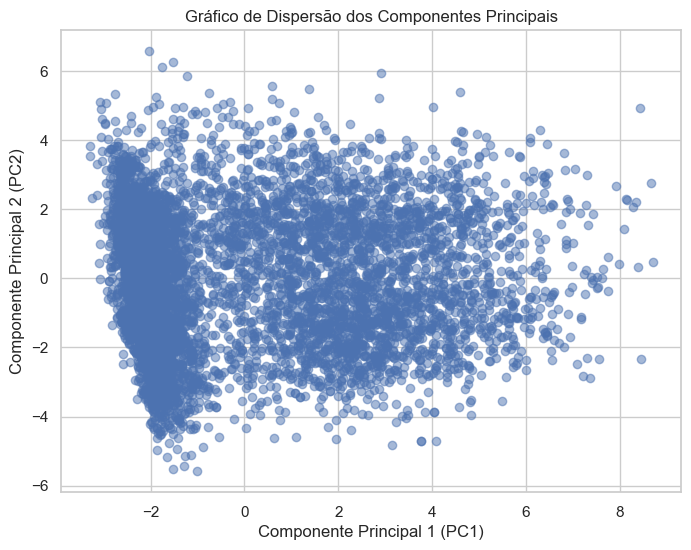

In [26]:
# Calcular os componentes principais
pca = PCA(n_components=2)  # Vamos manter apenas 2 componentes principais para visualização
componentes_principais = pca.fit_transform(QuebrasFinal.iloc[:, indices_col_numericas])

# Criar um DataFrame com os componentes principais
df_componentes_principais = pd.DataFrame(data=componentes_principais, columns=['PC1', 'PC2'])

# Plotar um gráfico de dispersão dos componentes principais
plt.figure(figsize=(8, 6))
plt.scatter(df_componentes_principais['PC1'], df_componentes_principais['PC2'], alpha=0.5)
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.title('Gráfico de Dispersão dos Componentes Principais')
plt.grid(True)
plt.show()

In [27]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.22192508 0.12547061]
[210.38124865 158.1884754 ]


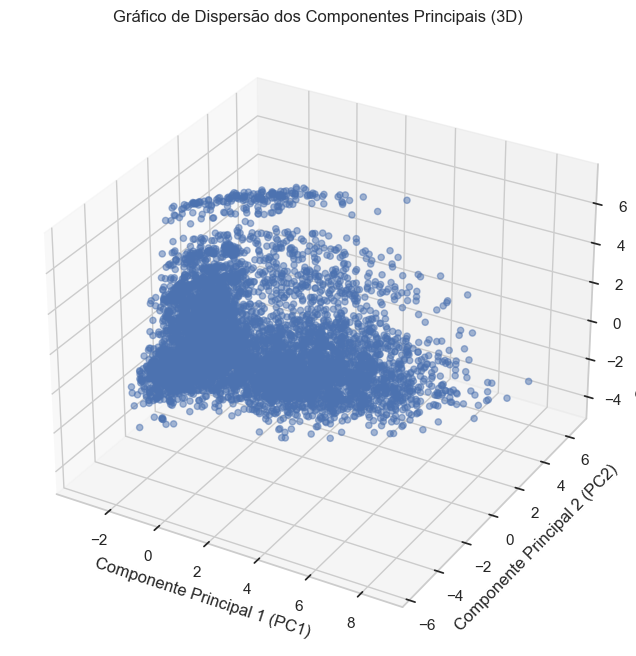

In [28]:
# Calcular os componentes principais
pca = PCA(n_components=3)  # Vamos manter 3 componentes principais
componentes_principais = pca.fit_transform(QuebrasFinal.iloc[:, indices_col_numericas])

# Criar um DataFrame com os componentes principais
df_componentes_principais = pd.DataFrame(data=componentes_principais, columns=['PC1', 'PC2', 'PC3'])

# Plotar um gráfico de dispersão dos componentes principais
from mpl_toolkits.mplot3d import Axes3D  # Importar a biblioteca para gráficos 3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_componentes_principais['PC1'], df_componentes_principais['PC2'], df_componentes_principais['PC3'], alpha=0.5)
ax.set_xlabel('Componente Principal 1 (PC1)')
ax.set_ylabel('Componente Principal 2 (PC2)')
ax.set_zlabel('Componente Principal 3 (PC3)')
ax.set_title('Gráfico de Dispersão dos Componentes Principais (3D)')
plt.show()


In [29]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.22192508 0.1254706  0.10756631]
[210.38124854 158.18847132 146.46773519]


## Modelling

In [30]:
colunas_numericas

Index(['Duração incidente (min)', 'N.º clientes afetados', 'TIEPI MT (min)',
       'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)',
       'SAIDI BT (min)', 'Ano', 'Densidade Populacional', 'Setor Primário',
       'Setor Secundário', 'Setor Terciário', 'Indice de Envelhecimento',
       'Rural', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED',
       'FF_MAX', 'PR_QTD', 'Ser_BT?', 'Animais', 'Animais - Intenção', 'Clima',
       'Humanos - Acidentes', 'SenoData', 'CossenoData'],
      dtype='object')

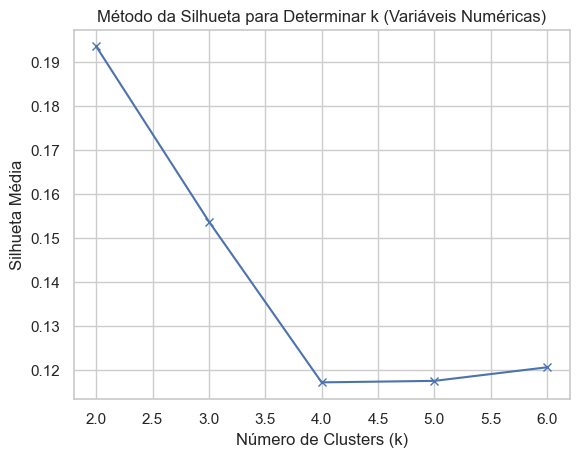

In [31]:
# Valores de k que você deseja testar
k_values = range(2, 7)

# Lista para armazenar os valores de silhueta média
silhouette_scores = []

# Iterar sobre os valores de k
for k in k_values:
    # Criar o modelo de clustering K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Treinar o modelo nos dados
    kmeans.fit(QuebrasFinal.iloc[:, indices_col_numericas])
    # Obter as etiquetas de cluster para cada ponto
    labels = kmeans.labels_
    # Calcular o score de silhueta
    silhouette_avg = silhouette_score(QuebrasFinal.iloc[:, indices_col_numericas], labels)
    # Armazenar o score de silhueta na lista
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico do Método do Cotovelo
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhueta Média')
plt.title('Método da Silhueta para Determinar k (Variáveis Numéricas)')
plt.show()


C:\Users\diogo\scoop\apps\anaconda3\2022.10\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\diogo\scoop\apps\anaconda3\2022.10\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


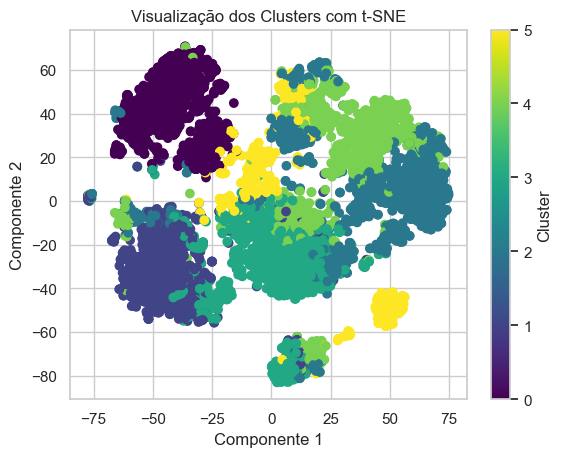

In [32]:
# Reduzir a dimensionalidade dos dados para 2 dimensões usando t-SNE
tsne = TSNE(n_components=2, random_state=69)
data_2d = tsne.fit_transform(QuebrasFinal.iloc[:, indices_col_numericas])

# Plotar os pontos em um gráfico de dispersão, colorindo-os de acordo com os clusters
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
plt.title('Visualização dos Clusters com t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Cluster')
plt.show()

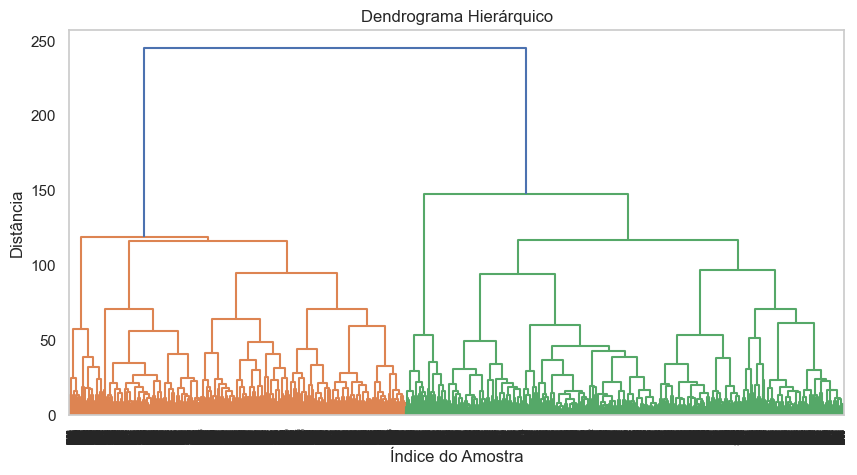

In [33]:
# Executar o algoritmo de clustering hierárquico nos teus próprios dados
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(QuebrasFinal.iloc[:, indices_col_numericas])

# Função para plotar o dendrograma
def plot_dendrogram(model, **kwargs):
    # Calcula o layout do dendrograma
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # folha
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plota o dendrograma
    dendrogram(linkage_matrix, **kwargs)

# Plotando o dendrograma
plt.figure(figsize=(10, 5))
plt.title('Dendrograma Hierárquico')
plot_dendrogram(model)
plt.xlabel('Índice do Amostra')
plt.ylabel('Distância')
plt.grid(False)
plt.show()


In [34]:
# Inicialize o modelo Agglomerative Clustering com o número desejado de clusters
n_clusters = 4  # Defina o número de clusters desejado
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Ajuste o modelo aos dados
agg_clustering.fit(QuebrasFinal.iloc[:, indices_col_numericas])

# Obtenha as etiquetas de cluster para cada amostra
cluster_labels = agg_clustering.labels_

# Adicione as etiquetas de cluster ao DataFrame QuebrasFinal
QuebrasFinal['Cluster_Agglomerative'] = cluster_labels

Silhouette média para o modelo Agglomerative Clustering: 0.16883473007990926


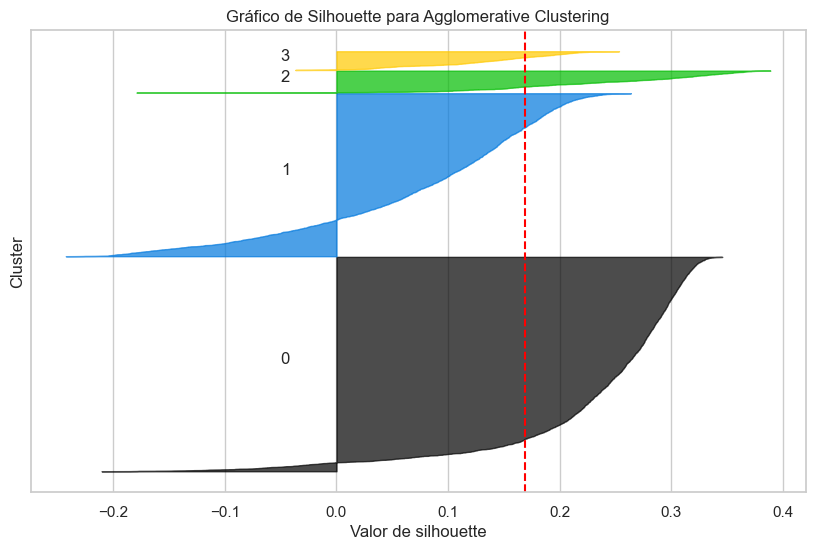

In [35]:
# Calcule a silhouette média para o modelo
silhouette_avg = silhouette_score(QuebrasFinal.iloc[:, indices_col_numericas], cluster_labels)
print("Silhouette média para o modelo Agglomerative Clustering:", silhouette_avg)

# Calcule a silhouette para cada amostra
sample_silhouette_values = silhouette_samples(QuebrasFinal.iloc[:, indices_col_numericas], cluster_labels)

# Crie um gráfico de barras para mostrar a silhouette para cada amostra
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(n_clusters):
    # Agregue a silhouette para amostras pertencentes ao cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Etiqueta do cluster no meio
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calcule o próximo y_lower para o próximo gráfico
    y_lower = y_upper + 10  

plt.title("Gráfico de Silhouette para Agglomerative Clustering")
plt.xlabel("Valor de silhouette")
plt.ylabel("Cluster")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")  # Linha para indicar a silhouette média
plt.yticks([])  # Limpe os yticks
plt.show()


In [36]:
QuebrasFinal["Cluster_Agglomerative"].unique()

array([1, 0, 2, 3], dtype=int64)

In [37]:
QuebrasFinal["Cluster_Agglomerative"] = QuebrasFinal["Cluster_Agglomerative"].astype(int)
indices_col_numericas = np.append(indices_col_numericas, QuebrasFinal.shape[1] - 1)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),...,FF_MAX,PR_QTD,Ser_BT?,Animais,Animais - Intenção,Clima,Humanos - Acidentes,SenoData,CossenoData,Cluster_Agglomerative
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,-1.010792,-0.032791,-0.159443,-0.378273,-0.415923,-0.145194,0.499487,...,-0.198123,-0.367508,-1.068771,-0.486802,-0.498343,-0.233459,0.890374,0.003044,1.544262,1
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,0.300274,-0.243748,-0.159612,0.445224,0.871489,-0.145366,0.118604,...,-0.592220,-0.367508,-1.068771,-0.486802,-0.498343,-0.233459,0.890374,0.003044,1.544262,1
2,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,0.482367,-0.581733,-0.655758,-0.653186,-0.641083,-0.652376,-0.492309,...,1.079844,1.379561,0.935654,-0.486802,-0.498343,-0.233459,0.890374,0.074743,1.539762,0
3,EDPD_2018_JAN_T_5,Nisa,2018-01-09,-0.233864,0.649984,0.092157,0.308078,0.279033,0.111917,-0.199771,...,1.512274,1.736916,-1.068771,2.054223,-0.498343,-0.233459,-1.123123,0.169813,1.527787,1
4,EDPD_2018_JAN_T_6,Esposende,2018-01-12,-0.755862,-0.613490,-0.655758,-0.653186,-0.641083,-0.652376,-0.549816,...,-0.240559,-0.182213,0.935654,-0.486802,-0.498343,-0.233459,0.890374,0.240471,1.514355,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,EDPD_2017_NOV_T_61,Esposende,2017-11-25,1.174319,-0.657345,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,-0.414660,-0.195448,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-0.731700,1.356409,0
6787,EDPD_2017_NOV_T_62,Ovar,2017-11-29,0.992226,-0.657345,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,-0.340958,-0.367508,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-0.646847,1.402588,0
6788,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,-0.561630,-0.658101,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,-0.349455,0.363256,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-1.130262,1.003072,0
6789,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,-0.209585,-0.658101,-0.655758,-0.653186,-0.641083,-0.652376,-0.631494,...,-0.303483,0.704557,0.935654,-0.486802,-0.498343,-0.233459,0.890374,-0.772931,1.331069,0


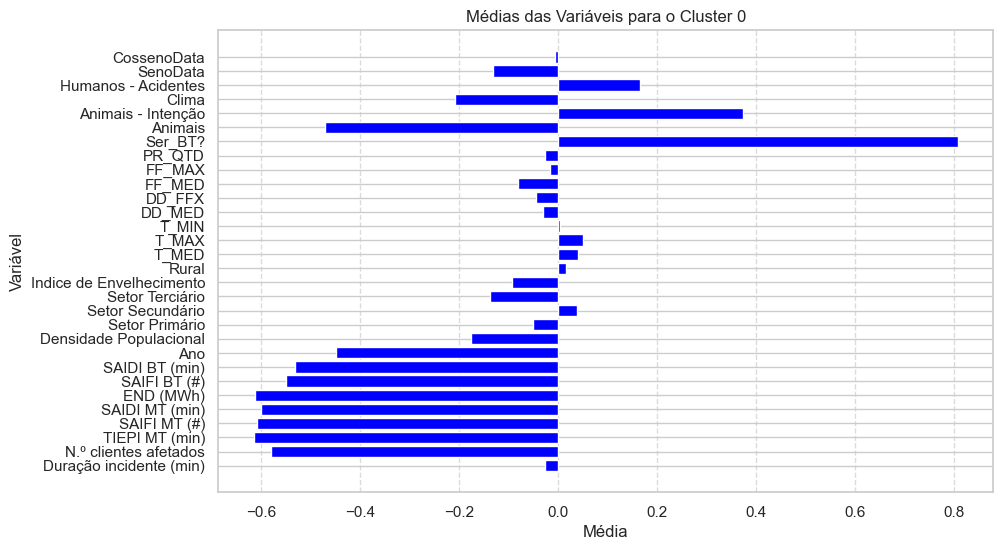

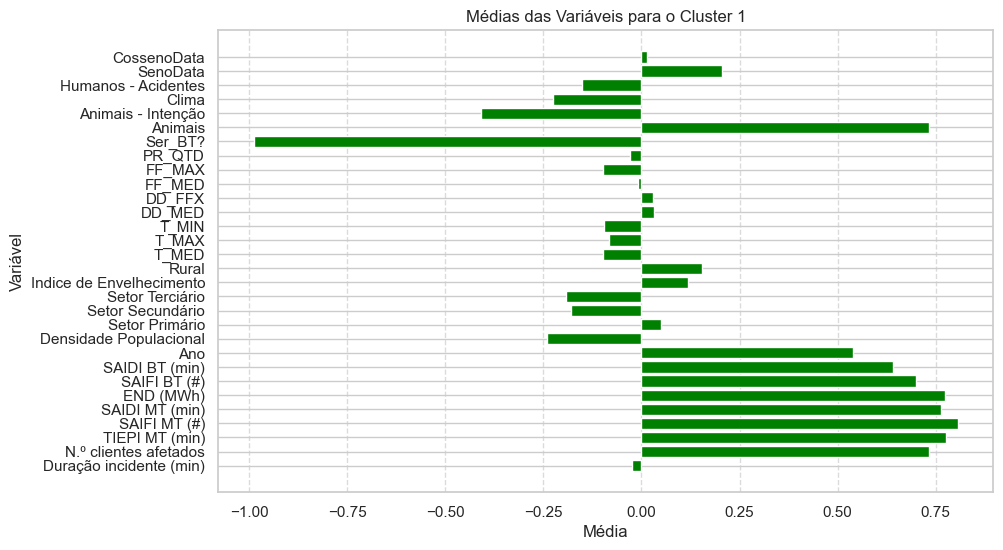

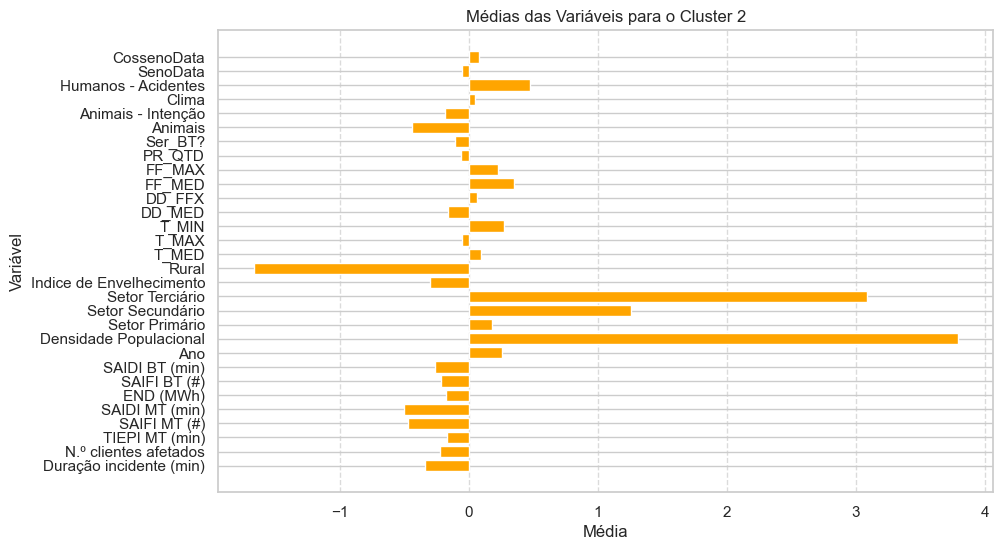

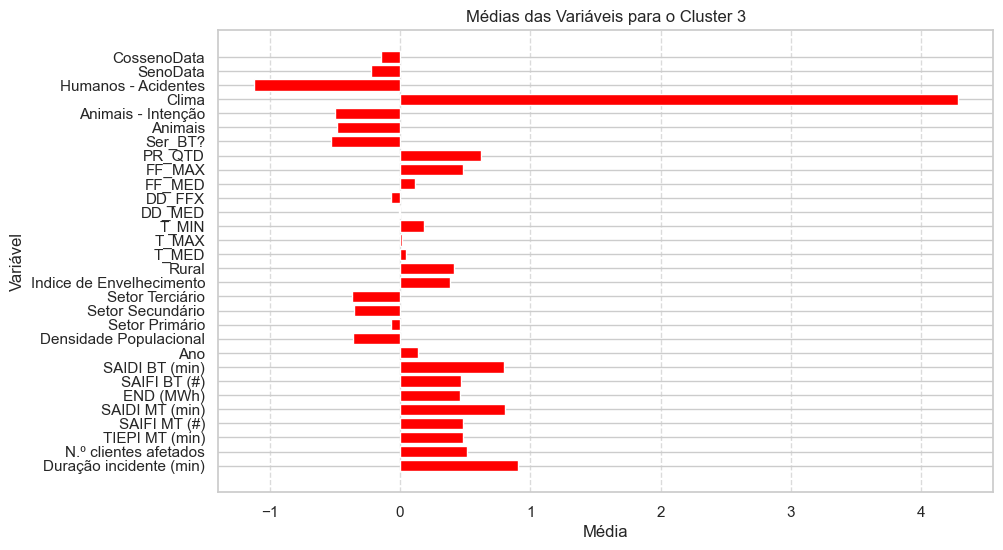

In [38]:
# Agrupar os dados por cluster e calcular as médias
cluster_means = QuebrasFinal.iloc[:, indices_col_numericas].groupby('Cluster_Agglomerative').mean()

# Definir cores para os clusters
colors = ['blue', 'green', 'orange', 'red']

# Plotar os gráficos de barras para cada cluster
for i, cluster in enumerate(cluster_means.index):
    cluster_data = cluster_means.loc[cluster]
    plt.figure(figsize=(10, 6))
    plt.barh(cluster_data.index, cluster_data.values, color=colors[i])
    plt.title(f'Médias das Variáveis para o Cluster {cluster}')
    plt.xlabel('Média')
    plt.ylabel('Variável')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

In [39]:
# Criar a tabela pivô
pivot_table = QuebrasFinal.pivot_table(index='Concelho', columns='Cluster_Agglomerative', aggfunc='size', fill_value=0)

# Renomear as colunas
pivot_table.columns = ['Cluster_' + str(col) for col in pivot_table.columns]

# Exibir a tabela pivô
pivot_table

,Cluster_0,Cluster_1,Cluster_2,Cluster_3
Concelho,,,,
Abrantes,14,25,0,0
Aguiar Da Beira,10,1,0,0
Alandroal,9,6,0,2
Albergaria-A-Velha,16,16,0,1
Albufeira,11,8,0,3
...,...,...,...,...
Vouzela,21,23,0,0
Águeda,33,35,0,5
Évora,16,31,0,2


In [40]:
file_path = shape_folder / "concelhos.shp"
Concelho = gpd.read_file(file_path)
Concelho.rename(columns={'NAME_1': 'Distrito'}, inplace=True)
Concelho.rename(columns={'NAME_2': 'Concelho'}, inplace=True)
Concelho["Concelho"] = Concelho["Concelho"].str.title()
Concelho = Concelho[~Concelho['Distrito'].isin(['Azores', 'Madeira'])]
Concelho

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,Concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,182,PRT,Portugal,1,Évora,1,Évora,PT.EV.EV,0,0705,Concelho,Municipality,None,None,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506..."
1,182,PRT,Portugal,1,Évora,2,Alandroal,PT.EV.AL,0,0701,Concelho,Municipality,None,None,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343..."
2,182,PRT,Portugal,1,Évora,3,Arraiolos,PT.EV.AR,0,0702,Concelho,Municipality,None,None,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472..."
3,182,PRT,Portugal,1,Évora,4,Borba,PT.EV.BO,0,0703,Concelho,Municipality,None,None,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329..."
4,182,PRT,Portugal,1,Évora,5,Estremoz,PT.EV.ES,0,0704,Concelho,Municipality,None,None,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,182,PRT,Portugal,20,Viseu,302,Tarouca,PT.VI.TR,0,1820,Concelho,Municipality,None,None,"POLYGON ((-7.72591 41.08079, -7.72442 41.08028..."
304,182,PRT,Portugal,20,Viseu,303,Tondela,PT.VI.TO,0,1821,Concelho,Municipality,None,None,"POLYGON ((-8.12772 40.64028, -8.12751 40.64027..."
305,182,PRT,Portugal,20,Viseu,304,Vila Nova De Paiva,PT.VI.VP,0,1822,Concelho,Municipality,None,None,"POLYGON ((-7.77933 40.93439, -7.77835 40.93436..."
306,182,PRT,Portugal,20,Viseu,305,Viseu,PT.VI.VS,0,1823,Concelho,Municipality,None,None,"POLYGON ((-7.80686 40.83789, -7.80653 40.83787..."


In [41]:
Bilada = set(pivot_table.index) - set(Concelho["Concelho"])
Bilada

{'Guimarães', 'Tavira'}

In [42]:
Freguesias_com_clusters = Concelho.merge(pivot_table, left_on='Concelho', right_index=True, how="left")
Freguesias_com_clusters.fillna(0, inplace=True)
Freguesias_com_clusters

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,Concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry,Cluster_0,Cluster_1,Cluster_2,Cluster_3
0,182,PRT,Portugal,1,Évora,1,Évora,PT.EV.EV,0,0705,Concelho,Municipality,0,0,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506...",16.0,31.0,0.0,2.0
1,182,PRT,Portugal,1,Évora,2,Alandroal,PT.EV.AL,0,0701,Concelho,Municipality,0,0,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343...",9.0,6.0,0.0,2.0
2,182,PRT,Portugal,1,Évora,3,Arraiolos,PT.EV.AR,0,0702,Concelho,Municipality,0,0,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472...",5.0,9.0,0.0,1.0
3,182,PRT,Portugal,1,Évora,4,Borba,PT.EV.BO,0,0703,Concelho,Municipality,0,0,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329...",3.0,2.0,0.0,1.0
4,182,PRT,Portugal,1,Évora,5,Estremoz,PT.EV.ES,0,0704,Concelho,Municipality,0,0,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066...",11.0,7.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,182,PRT,Portugal,20,Viseu,302,Tarouca,PT.VI.TR,0,1820,Concelho,Municipality,0,0,"POLYGON ((-7.72591 41.08079, -7.72442 41.08028...",6.0,0.0,0.0,0.0
304,182,PRT,Portugal,20,Viseu,303,Tondela,PT.VI.TO,0,1821,Concelho,Municipality,0,0,"POLYGON ((-8.12772 40.64028, -8.12751 40.64027...",21.0,11.0,0.0,3.0
305,182,PRT,Portugal,20,Viseu,304,Vila Nova De Paiva,PT.VI.VP,0,1822,Concelho,Municipality,0,0,"POLYGON ((-7.77933 40.93439, -7.77835 40.93436...",5.0,2.0,0.0,1.0
306,182,PRT,Portugal,20,Viseu,305,Viseu,PT.VI.VS,0,1823,Concelho,Municipality,0,0,"POLYGON ((-7.80686 40.83789, -7.80653 40.83787...",36.0,41.0,0.0,3.0


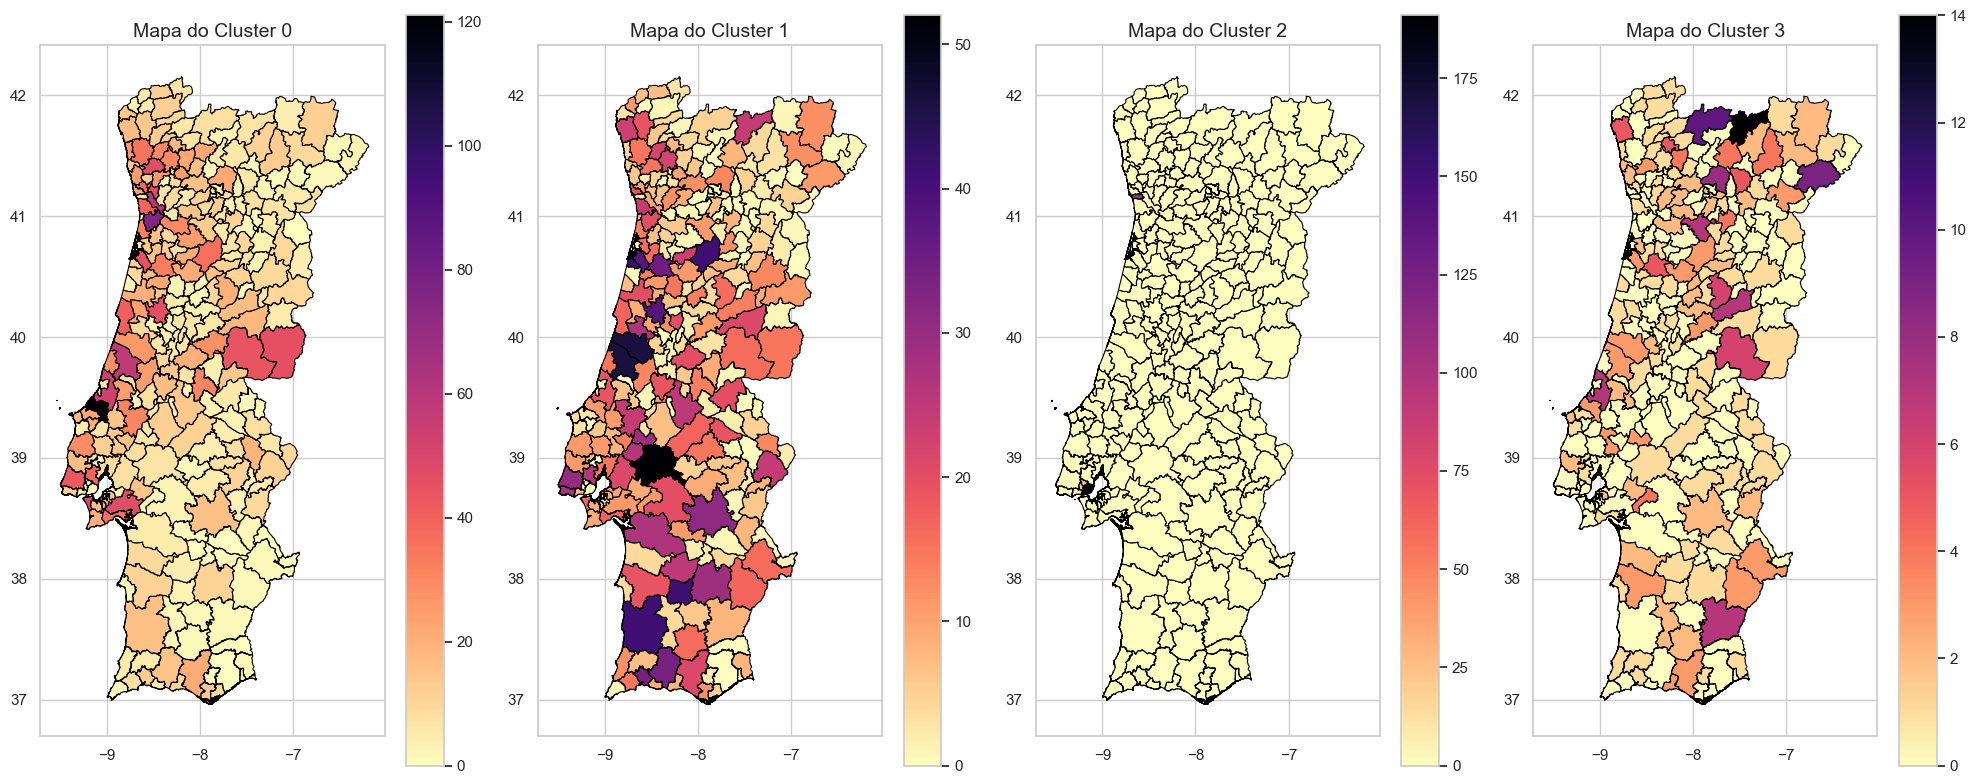

In [54]:
# Configurar a figura e os eixos para a grade de subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 8))

# Iterar sobre cada cluster e plotar o mapa correspondente
for i, cluster in enumerate(['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']):
    # Plotar o mapa das freguesias para o cluster atual
    Freguesias_com_clusters.plot(column=cluster, cmap='magma_r', linewidth=0.8, edgecolor='black', ax=axs[i], legend=True)
    
    # Adicionar título para cada subplot
    axs[i].set_title(f'Mapa do Cluster {i}', fontsize=14)

# Exibir os mapas
plt.tight_layout()
plt.show()

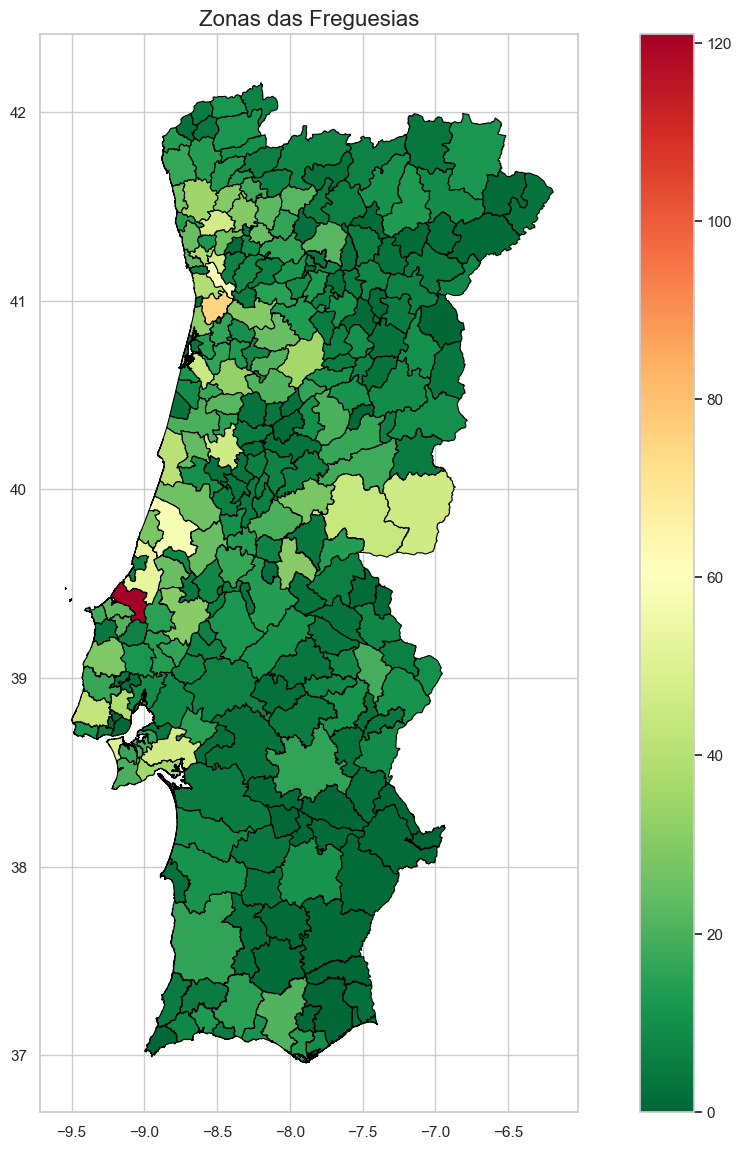

In [47]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(16, 14))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_0', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Exibir o mapa
plt.show()

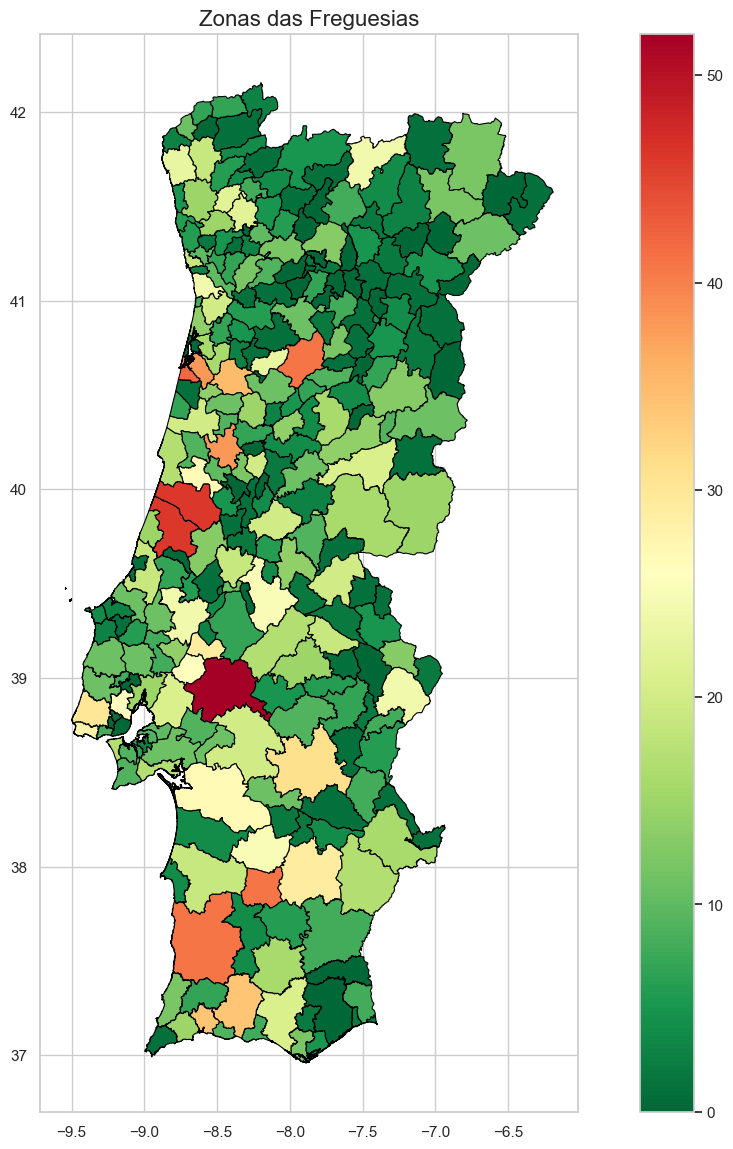

In [48]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(16, 14))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_1', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Exibir o mapa
plt.show()

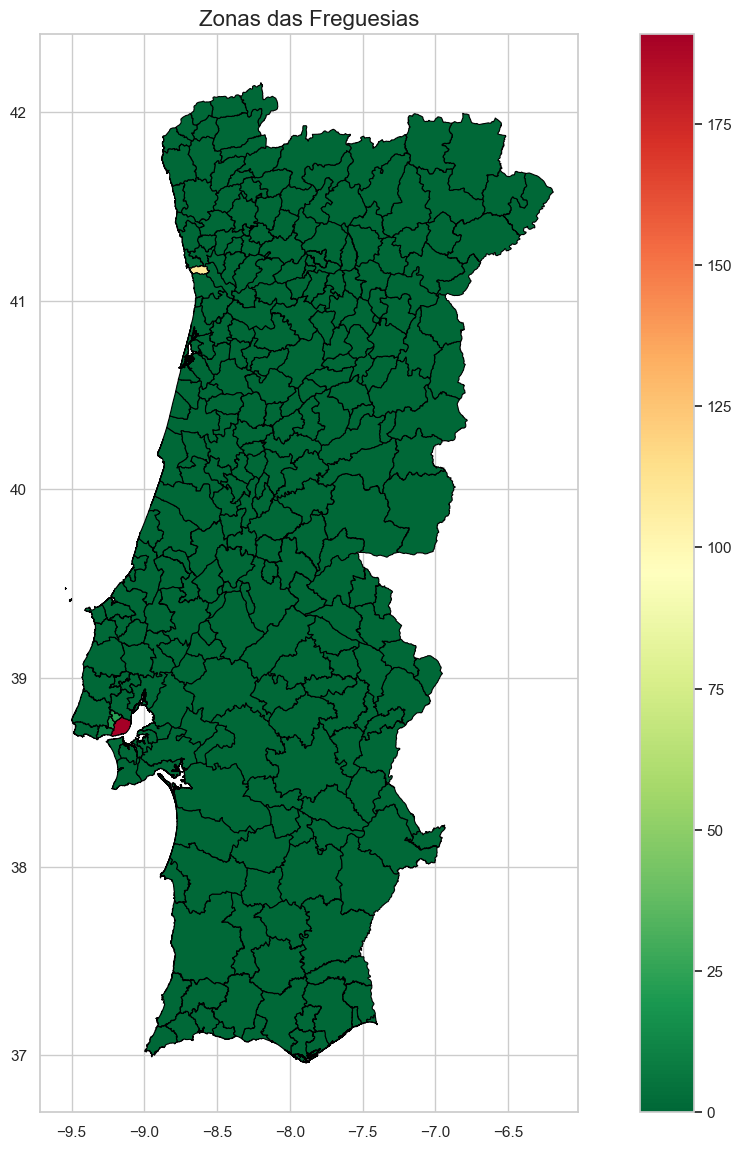

In [49]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(16, 14))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_2', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Exibir o mapa
plt.show()

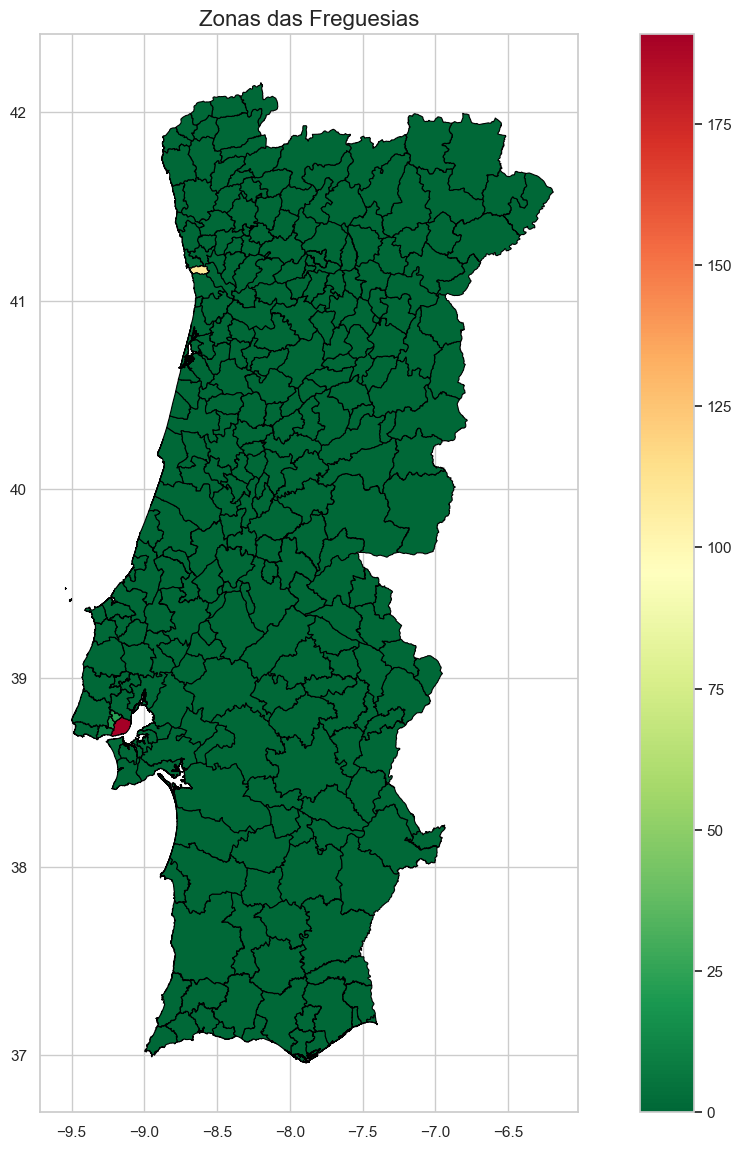

In [50]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(16, 14))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_2', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Exibir o mapa
plt.show()